# Base de datos de anime en MongoDb y analisis exploratorio de datos.

>_**Autor:** Nelson David Camacho Ovalle_

>_Universidad Nacional de Colombia: Facultad de Ingienería_
___

# **1. Entendimiento del negocio.**

Las principales utilidades que ofrece una base de datos a un servicio son agrupar, almacenar y asegurar seguridad de todos los datos necesarios en un único lugar, facilitando que se compartan entre los diferentes agentes de un servicio.  Las bases de datos en la nube brindad la capacidad de adaptarse al crecimiento, alta velocidad y capaces de funcionar aun cuando se presenten fallas en algun componente.

Algunas bases de datos disponibles en internet, encontradas en paginas como *Kaggle.com* no se encuentran disponibles para ser usadas en un entorno en la nube, por lo que en primera instancia, es necesario adaptarlas a estas tecnologias.

Seleccionando una de ellas, la base de datos [*Anime Recommendation Database 2020*](https://www.kaggle.com/hernan4444/anime-recommendation-database-2020), es un conjunto de datos que contiene información documental sobre 17.562 animes que puede ser utilizada en diferentes servicios y contextos, por ejemplo, un servicio de Streaming como *Netflix*. Para gestionar esta base de datos en un servicio en la nube, este sistema debe permitir altos números de transacciones de consulta, escritura o actualizaciones, siendo de un esquema *NoSQL* mucho más eficiente cubriendo estas necesidades.

El alto rendimiento y la alta escalabilidad del motor de base de datos NoSQL *MongoDB* lo hace ideal para un sistema de este tipo.


<img src="https://3.bp.blogspot.com/-UbCyssyVec8/T9VYmFfvEWI/AAAAAAAARvg/bfbVdkAY-T8/s1600/3666796961_51837dd566_o.jpg" alt="Dogecoin y Elon Musk" width="680" height="450">

Por lo siguiente, los objetivos de este proyecto son:


### **Objetivo del proyecto**

- Seleccionar caracteristicas relevantes de la base de datos "*Anime Recommendation Database 2020*" y convertirla en un formato compatible al motor de base de datos.
- Integrar la base de datos al motor MongoDB.
- Realizar una exploración de datos inicial utilizando operaciones DML (*Lenguaje de manipulación de datos*), consultas mediante el algoritmo *MapReduce* y visualización simple de datos. 

## **Metodologia**

CRISP-DM

<img src="https://www.section.io/engineering-education/data-mining-using-crisp-dm-methodology/crisp-dm-framework.png" alt="Crisp-DM" width="640" height="380">

# **Diagrama de despliegue**

En este diagrama de despliegue basico, se establece inicialmente:

1. Cuenta con tres nodos iniciales, suponiendo que se podria aplicar en un servicio web como Netflix o Crunchyroll
2. Se establece que el nodo del servidor, el MongoDB se esta aplicando de manera *Standalone* y no se trabaja con multiples nodos usando *Sharding*
3. El servicio web compromete dos componentes, las cuales se basan en el front-end y el back-end siendo administada por Python mediante la libreria de Pymongo, o usada por JavaScript como back-end.
4. El cliente, es el computador que consume los servicios de la pagina web en base a la colección de datos realizada en este *Notebook*.

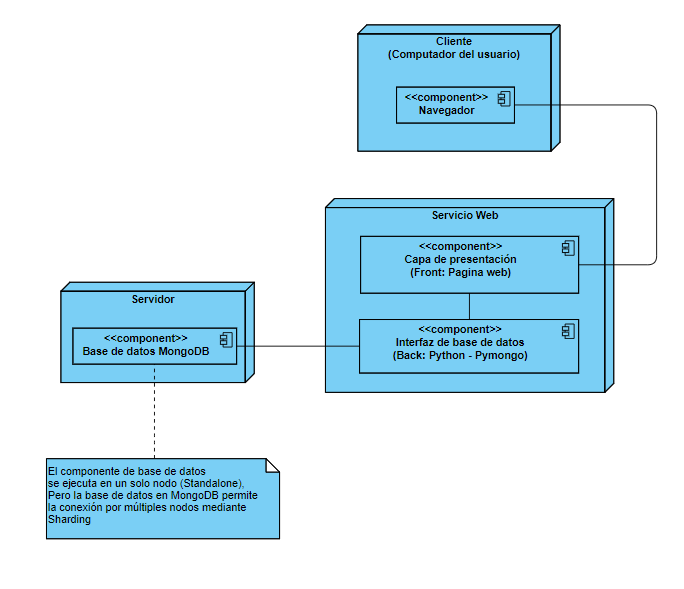

**NOTA**: Ejecutar este notebook en un entorno compatible con Plotly ya que todas las graficas utilizadas en este proyecto son interectivas.

# **2. Datos**
___


## **2.1. Dependencias y conexión**
Importamos las librerías necesarias y se establecen parametros de configuración de la herramienta de base de datos  que vamos a usar en el proyecto. Librerias como *PyMongo* que permite al entorno *Python* conectarse a *MongoDB* mediante de una instalación local o remota del servicio.
___

In [ ]:
# Actualizamos el repositorio e instalamos mongodb.
!sudo apt -qq update
!sudo apt -qq install -y mongodb

47 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following additional packages will be installed:
  libpcap0.8 libstemmer0d libyaml-cpp0.5v5 mongo-tools mongodb-clients
  mongodb-server mongodb-server-core
The following NEW packages will be installed:
  libpcap0.8 libstemmer0d libyaml-cpp0.5v5 mongo-tools mongodb mongodb-clients
  mongodb-server mongodb-server-core
0 upgraded, 8 newly installed, 0 to remove and 47 not upgraded.
Need to get 53.1 MB of archives.
After this operation, 215 MB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 8.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open s

In [ ]:
# Creamos los directorios 'data' y 'log'.
!mkdir -p data log

# Ejecutamos el servicio de Mongo.
!mongod --dbpath ./data --logpath ./log/mongod.log --fork

about to fork child process, waiting until server is ready for connections.
forked process: 1803
child process started successfully, parent exiting


In [ ]:
# Importar librerias

# Libreria pymongo
import pymongo

# Librerias NumPy y Pandas 
import numpy as np
import pandas as pd

# Libreria Plotly
!pip install -U plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px

     |████████████████████████████████| 13.2MB 226kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


Para la conexión de *PyMongo* con el servidor de *MongoDB* es necesario establecer una conexión con la dirección ip (*En este caso, localhost* que representa la IP de la máquina local) y el puerto por defecto **27017**

In [ ]:
# Conexión al servidor de MongoDB

client = pymongo.MongoClient("localhost", 27017)
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

## **2.2. Variables**

Antes de convetir la base de datos propuesta, es necesario crear la base de datos y la colección en la que se van a implementar. Para esto, se crea un cliente llamado '*AnimeDB*' con una colección llamada *'anime'*.



In [ ]:
# Crear la base
db = client['animeDB']
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'animeDB')

In [ ]:
# Declaramos la colección (sintaxis de atributo).
col = db.anime
col

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'animeDB'), 'anime')

## **2.3 Conjunto de datos (Dataset)**
Este conjunto de datos contiene información sobre diferentes animes y la preferencia de 325.772 usuarios diferentes. En particular, esta base de datos contiene:

 - Calificaciones dadas por los usuarios a los animes que han visto completamente.
 - Información sobre el anime como género, estadísticas, estudio, etc.
 - HTML con información del anime para hacer scrapping de datos. Estos archivos contienen información como reseñas, sinopsis, información sobre el equipo, estadísticas del anime, género, etc.

En este caso particular, solamente se utilizará el archivo *anime.csv* que contiene información general de cada anime (17.562 animes diferentes) como género, estadísticas, producción, etc.

> *Mas información: https://www.kaggle.com/hernan4444/anime-recommendation-database-2020*



In [ ]:
# Dataset

tempAnime = pd.read_csv('https://drive.google.com/u/0/uc?id=1IN3X99Kzaqmgi6_sf6JyvVJXl0JHPPaP&export=download')

In [ ]:
tempAnime.head()

,MAL_ID,Name,Score,Genders,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [ ]:
# Dimensiones
tempAnime.shape

(17562, 35)

## **2.3. Descripción  y preparación de los datos**
___
Con el fin de proseguir, es necesario entender que corresponde cada variable con su descripción y así realizar el proceso de la preparación de los datos.

| Variable      | Descripción                                                  |
| ------------- | ------------------------------------------------------------ |
| MAL_ID        | ID del anime en la pagina *MyAnimelist*                      |
| Name          | Nombre completo del anime                                    |
| Score         | Puntuación media del anime otorgada por todos los usuarios de la base de datos de MyAnimelist |
| Genders       | Lista de géneros separados por comas para este anime.        |
| English name  | Nombre completo en inglés del anime.                         |
| Japanese name | Nombre completo en japonés del anime                         |
| Type          | TV, película, OVA, etc.                                      |
| Episodes      | Número de capítulos.                                         |
| Aired         | Fechas de emisión                                            |
| Premiered     | Estreno de la temporada                                      |
| Producers     | Lista de productores separada por comas                      |
| Licensors     | Lista de licenciadores separada por comas                    |
| Studios       | Lista de estudios separada por comas                         |
| Source        | Manga, novela ligera, libro, etc.                            |
| Duration      | Duración del anime por episodio                              |
| Rating        | Clasificación: índice de edad                                |
| Ranked        | Posición basada en la puntuación.                            |
| Popularity    | Posición basada en el número de usuarios que han añadido el anime a su lista |
| Members       | Número de miembros de la comunidad que están en el "grupo" de este anime. |
| Favorites     | Número de usuarios que tienen el anime como "favoritos".     |
| Watching      | Número de usuarios que están viendo el anime                 |
| Completed     | Número de usuarios que han completado el anime.              |
| On-Hold       | Número de usuarios que tienen el anime en espera.            |
| Dropped       | Número de usuarios que han abandonado el anime.              |
| Plan to Watch | Número de usuarios que planean ver el anime                  |
| Score-10      | Número de usuarios que han puntuado 10                       |
| Score-9       | Número de usuarios que han puntuado 9                        |
| Score-8       | Número de usuarios que han puntuado 8                        |
| Score-7       | Número de usuarios que han puntuado 7                        |
| Score-6       | Número de usuarios que han puntuado 6                        |
| Score-5       | Número de usuarios que han puntuado 5                        |
| Score-4       | Número de usuarios que han puntuado 4                        |
| Score-3       | Número de usuarios que han puntuado 3                        |
| Score-2       | Número de usuarios que han puntuado 2                        |
| Score-1       | Número de usuarios que han puntuado 1                        |


Con fines prácticos, la base de datos que se implementará en *MongoDB* no contendrá la totalidad de las variables. Se eliminarán variables poco relevantes con el fin de tener una base de datos muestra que represente a la original, como los nombres del mismo anime en japones y en ingles, licenciadores y variables como el numero de usuarios que han puntuado del 1 al 10, entre otras.

Las variables a seleccionar son:

- MAL_ID
- Name
- Score
- Genders
- Type 
- Aired
- Episodes
- Producers 
- Studios
- Source 
- Duration
- Watching
- Ranked
- Popularity


In [ ]:
# Base de datos con las variables seleccionadas

cols = ['MAL_ID', 'Name', 'Score', 'Genders', 'Type', 'Aired' ,'Episodes', 'Producers', 'Studios', 'Source', 'Duration', 'Watching', 'Ranked', 'Popularity']
animeDF = pd.DataFrame(tempAnime[cols])
animeDF.head()

,MAL_ID,Name,Score,Genders,Type,Aired,Episodes,Producers,Studios,Source,Duration,Watching,Ranked,Popularity
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,"Apr 3, 1998 to Apr 24, 1999",26,Bandai Visual,Sunrise,Original,24 min. per ep.,105808,28.0,39
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,"Sep 1, 2001",1,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,4143,159.0,518
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,"Apr 1, 1998 to Sep 30, 1998",26,Victor Entertainment,Madhouse,Manga,24 min. per ep.,29113,266.0,201
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,"Jul 2, 2002 to Dec 24, 2002",26,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Sunrise,Original,25 min. per ep.,4300,2481.0,1467
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,"Sep 30, 2004 to Sep 29, 2005",52,"TV Tokyo, Dentsu",Toei Animation,Manga,23 min. per ep.,642,3710.0,4369


Algunas variables comprometen valores desconocidos '***Unknown***' en función al siguiente criterio.

<br>

| Variable   | Criterio de valores desconocidos                             |
| ---------- | ------------------------------------------------------------ |
| Episodes   | El anime aun sigue en emisión y no hay un valor de episodios estatico. |
| Ranked     | No hay una posición basada en puntuación.                    |
| Score      | Los usuarios no puntuaron el anime (Hay animes que aun no han salido en emisión y esta disponible la infomación en la base de datos) |
| Popularity | No hay usuarios que hayan añadido el anime a su lista        |

<br>

Como son variables cuantitativas, se hace una transformación de la cadena de texto '***Unknown***' al valor $-1$ para su correspondiente congruencia con el tipo de variable a la implementación a *MongoDB*


In [ ]:
# Transformación de la cadena 'Unknown' a -1

animeDF['Episodes'] = animeDF['Episodes'].replace(['Unknown'],-1)
animeDF['Ranked'] = animeDF['Ranked'].replace(['Unknown'],-1)
animeDF['Score'] = animeDF['Score'].replace(['Unknown'],-1)
animeDF['Popularity'] = animeDF['Popularity'].replace(['Unknown'],-1)

In [ ]:
print(
    len(animeDF[animeDF['Episodes'] == 'Unknown']),
    len(animeDF[animeDF['Ranked'] == 'Unknown']),
    len(animeDF[animeDF['Score'] == 'Unknown']),
    len(animeDF[animeDF['Popularity'] == 'Unknown']),
)

0 0 0 0


## **2.4. Formato** 

MongoDB almacena los datos bajo una estructura similar a ***JSON*** *(JavaScript Object Notation)* llamada ***BSON*** *(Binary JavaScript Object Notation)*

Por ello, la base de datos deben se adecuará a este formato para que el motor lo reciba correctamente.

El formato planteado es el siguiente:

```javascript
  [
    {
    'IDAnime': idDelAnime,
    'Nombre': nombreDelAnime,
    'ScoreAvg': puntuacion,
    'Genero': {
                  0: genero1,
                  1: genero2,
                  ...
                  n: generoN+1
              },
    'Tipo': tipo,
    'TiempoEmision': {
                        'Inicio': fechaDeinicio,
                        'Fin': fechaFin (Si esta disponible, sino la clave 'Fin' no esta)
                     }, 
    'CantEpisodios': cantidadDeEpisodios,
    'Productores': {
                      0: productor1,
                      1: productor2,
                      ...
                      n: productorN+1
                   },
    'Estudio': estudio,
    'Fuente': fuente,
    'Duracion': duracion,
    'Vistos': vistos,
    'Popularidad': popularidad,
    'Rank': rank,
    }
  ]
```




Para adaptar la base de datos al formato descrito anteriormente, se crean unas funciones que faciliten el proceso.

In [ ]:
def splitGenders(Gen):

    Gentemp = {}
    split = Gen.split(', ')

    for i in range(len(split)):
      Gentemp[f'{i}'] = split[i]

    return Gentemp

In [ ]:
def splitDate(Date):
  
  Datmp = {}
  tmp = Date.split(' to ')

  for i in range(len(tmp)):
      if (i == 0):
          msg = 'Inicio'
      else:
          msg = 'Fin'   

      Datmp[msg] = tmp[i]

  return Datmp


## **2.5. Conversión**

Se establece una función que convierte una fila de nuestra tabla en un diccionario de *Python* a partir del formato y se itera sobre la totalidad de filas de la base de datos correspondiente.

In [ ]:
# Función de conversión

def constBSON (df, idx): 
  return {
    'IDAnime': df['MAL_ID'][idx].item(), #Convierte numpy.int64 a valor de Python
    'Nombre': df['Name'][idx],
    'ScoreAvg': float(df['Score'][idx]),
    'Genero': splitGenders(df['Genders'][idx]) ,
    'Tipo': df['Type'][idx],
    'TiempoEmision': splitDate(df['Aired'][idx]), 
    'CantEpisodios': int(df['Episodes'][idx]),
    'Productores': splitGenders(df['Producers'][idx]),
    'Estudio': df['Studios'][idx],
    'Fuente': df['Source'][idx],
    'Duracion': df['Duration'][idx],
    'Vistos': df['Watching'][idx].item(),
    'Popularidad': df['Popularity'][idx].item(),
    'Rank': int(float(df['Ranked'][idx])),
    
  }

In [ ]:
# Convertir base de datos a BSON para integración a mongoDB

animeJS = []

for i in range(len(animeDF)):
    animeJS.append(constBSON(animeDF,i))

In [ ]:
# Primeros 5 valores

for i in range(5):
  print(animeJS[i])

{'IDAnime': 1, 'Nombre': 'Cowboy Bebop', 'ScoreAvg': 8.78, 'Genero': {'0': 'Action', '1': 'Adventure', '2': 'Comedy', '3': 'Drama', '4': 'Sci-Fi', '5': 'Space'}, 'Tipo': 'TV', 'TiempoEmision': {'Inicio': 'Apr 3, 1998', 'Fin': 'Apr 24, 1999'}, 'CantEpisodios': 26, 'Productores': {'0': 'Bandai Visual'}, 'Estudio': 'Sunrise', 'Fuente': 'Original', 'Duracion': '24 min. per ep.', 'Vistos': 105808, 'Popularidad': 39, 'Rank': 28}
{'IDAnime': 5, 'Nombre': 'Cowboy Bebop: Tengoku no Tobira', 'ScoreAvg': 8.39, 'Genero': {'0': 'Action', '1': 'Drama', '2': 'Mystery', '3': 'Sci-Fi', '4': 'Space'}, 'Tipo': 'Movie', 'TiempoEmision': {'Inicio': 'Sep 1, 2001'}, 'CantEpisodios': 1, 'Productores': {'0': 'Sunrise', '1': 'Bandai Visual'}, 'Estudio': 'Bones', 'Fuente': 'Original', 'Duracion': '1 hr. 55 min.', 'Vistos': 4143, 'Popularidad': 518, 'Rank': 159}
{'IDAnime': 6, 'Nombre': 'Trigun', 'ScoreAvg': 8.24, 'Genero': {'0': 'Action', '1': 'Sci-Fi', '2': 'Adventure', '3': 'Comedy', '4': 'Drama', '5': 'Shoune

In [ ]:
# Ejemplo de una fila
animeJS[11]

{'CantEpisodios': -1,
 'Duracion': '24 min.',
 'Estudio': 'Toei Animation',
 'Fuente': 'Manga',
 'Genero': {'0': 'Action',
  '1': 'Adventure',
  '2': 'Comedy',
  '3': 'Super Power',
  '4': 'Drama',
  '5': 'Fantasy',
  '6': 'Shounen'},
 'IDAnime': 21,
 'Nombre': 'One Piece',
 'Popularidad': 31,
 'Productores': {'0': 'Fuji TV', '1': 'TAP', '2': 'Shueisha'},
 'Rank': 95,
 'ScoreAvg': 8.52,
 'TiempoEmision': {'Fin': '?', 'Inicio': 'Oct 20, 1999'},
 'Tipo': 'TV',
 'Vistos': 887333}

# **3. Base de datos en *MongoDB***

Con el fin de proseguir, ya obtenida la base de datos en el formato *BSON*, es necesario implementarla en la colección 'anime' de la base de datos 'AnimeDB' utilizando el comando DDL *insert_many* para la inserción de multiples filas.

In [ ]:
# Inserción/Almacenamiento de la base de datos en formato BSON en la colección 'anime' en MongoDB

db.anime.insert_many(animeJS)

In [ ]:
# Consulta en formato cursor de pymongo

db.anime.find()

In [ ]:
# Visualización de las primeras 10 filas del cursor

for result in db.anime.find().limit(10):
  print(result)

{'_id': ObjectId('60cf49fe592211af0d24e1a1'), 'IDAnime': 1, 'Nombre': 'Cowboy Bebop', 'ScoreAvg': 8.78, 'Genero': {'0': 'Action', '1': 'Adventure', '2': 'Comedy', '3': 'Drama', '4': 'Sci-Fi', '5': 'Space'}, 'Tipo': 'TV', 'TiempoEmision': {'Inicio': 'Apr 3, 1998', 'Fin': 'Apr 24, 1999'}, 'CantEpisodios': 26, 'Productores': {'0': 'Bandai Visual'}, 'Estudio': 'Sunrise', 'Fuente': 'Original', 'Duracion': '24 min. per ep.', 'Vistos': 105808, 'Popularidad': 39, 'Rank': 28}
{'_id': ObjectId('60cf49fe592211af0d24e1a2'), 'IDAnime': 5, 'Nombre': 'Cowboy Bebop: Tengoku no Tobira', 'ScoreAvg': 8.39, 'Genero': {'0': 'Action', '1': 'Drama', '2': 'Mystery', '3': 'Sci-Fi', '4': 'Space'}, 'Tipo': 'Movie', 'TiempoEmision': {'Inicio': 'Sep 1, 2001'}, 'CantEpisodios': 1, 'Productores': {'0': 'Sunrise', '1': 'Bandai Visual'}, 'Estudio': 'Bones', 'Fuente': 'Original', 'Duracion': '1 hr. 55 min.', 'Vistos': 4143, 'Popularidad': 518, 'Rank': 159}
{'_id': ObjectId('60cf49fe592211af0d24e1a3'), 'IDAnime': 6, 'No

In [ ]:
# Numero total de filas en la base de datos MongoDB
count = db.anime.count_documents({})
count

17562

## **3.1. Guardado de la base de datos**

Ya establecida la base de datos en el entorno de MongoDB, se puede guardar el c ontenido de la colección en un archivo *.BSON* para su consumo en otro contexto utilizando la libreria ***bson.json_util***.



In [ ]:
# Guardar base de datos BSON en formato MongoDB
from bson.json_util import dumps
cursor = db.anime.find({})

with open('animeDB.bson', 'w') as file:
        file.write('[')
        for document in cursor:
            file.write(dumps(document))
            file.write(',')
        file.write(']')

In [ ]:
# Ejecutar esta celda si se desea descargar el archivo de la base de datos 'animeDB.bson' de manera automatica
# El archivo de la base de datos 'animeDB.bson' pesa 7,36 MB

# from google.colab import files
# files.download('animeDB.bson') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **4. Exploración de datos**

Utilizando la base de datos ya establecida en el entorno de *MongoDB*, se realiza una exploración inicial, con el fin de explorarlos mediante comandos DML y el algoritmo *MapReduce*

---


Se realiza una prueba de rendimiento frente a el tiempo que tarda Python en realizar la consulta usando PyMongo y la tabla obtenida por el CSV utilizando el comando magic ***%timeit*** obteniendo el tiempo promedio de repetidas iretaciones.

In [ ]:
 %timeit db.anime.find({})

The slowest run took 9.46 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.9 µs per loop


In [ ]:
 %timeit animeDF

10000000 loops, best of 5: 33.9 ns per loop


## **4.1. Consultas(*Queries*) - DML**

Con fines prácticos y exploratorios, se realizan consultas en la base de datos que den respuesta a situaciones comunes del contexto.

Se realizarán las siguientes consultas:

- Todos los animes de la colección
- ¿Cuál es el top 10 de animes mas esperados?
- ¿Cuál es el top 10 de animes con mejor ranking?
- Búsqueda de animes por el nombre
- Búsqueda de animes por tipo

**NOTA**: Se utilizará la libreria Pandas para la visualización de la consulta en un formato de tabla.

In [ ]:
# Todos los animes de la colección
pd.DataFrame(db.anime.find())

,_id,IDAnime,Nombre,ScoreAvg,Genero,Tipo,TiempoEmision,CantEpisodios,Productores,Estudio,Fuente,Duracion,Vistos,Popularidad,Rank
0,60cf49fe592211af0d24e1a1,1,Cowboy Bebop,8.78,"{'0': 'Action', '1': 'Adventure', '2': 'Comedy...",TV,"{'Inicio': 'Apr 3, 1998', 'Fin': 'Apr 24, 1999'}",26,{'0': 'Bandai Visual'},Sunrise,Original,24 min. per ep.,105808,39,28
1,60cf49fe592211af0d24e1a2,5,Cowboy Bebop: Tengoku no Tobira,8.39,"{'0': 'Action', '1': 'Drama', '2': 'Mystery', ...",Movie,"{'Inicio': 'Sep 1, 2001'}",1,"{'0': 'Sunrise', '1': 'Bandai Visual'}",Bones,Original,1 hr. 55 min.,4143,518,159
2,60cf49fe592211af0d24e1a3,6,Trigun,8.24,"{'0': 'Action', '1': 'Sci-Fi', '2': 'Adventure...",TV,"{'Inicio': 'Apr 1, 1998', 'Fin': 'Sep 30, 1998'}",26,{'0': 'Victor Entertainment'},Madhouse,Manga,24 min. per ep.,29113,201,266
3,60cf49fe592211af0d24e1a4,7,Witch Hunter Robin,7.27,"{'0': 'Action', '1': 'Mystery', '2': 'Police',...",TV,"{'Inicio': 'Jul 2, 2002', 'Fin': 'Dec 24, 2002'}",26,"{'0': 'TV Tokyo', '1': 'Bandai Visual', '2': '...",Sunrise,Original,25 min. per ep.,4300,1467,2481
4,60cf49fe592211af0d24e1a5,8,Bouken Ou Beet,6.98,"{'0': 'Adventure', '1': 'Fantasy', '2': 'Shoun...",TV,"{'Inicio': 'Sep 30, 2004', 'Fin': 'Sep 29, 2005'}",52,"{'0': 'TV Tokyo', '1': 'Dentsu'}",Toei Animation,Manga,23 min. per ep.,642,4369,3710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,60cf49fe592211af0d252636,48481,Daomu Biji Zhi Qinling Shen Shu,-1.00,"{'0': 'Adventure', '1': 'Mystery', '2': 'Super...",ONA,"{'Inicio': 'Apr 4, 2021', 'Fin': '?'}",-1,{'0': 'Unknown'},Unknown,Novel,Unknown,0,13116,-1
17558,60cf49fe592211af0d252637,48483,Mieruko-chan,-1.00,"{'0': 'Comedy', '1': 'Horror', '2': 'Supernatu...",TV,"{'Inicio': '2021', 'Fin': '?'}",-1,{'0': 'Kadokawa'},Passione,Manga,Unknown,14,17562,-1
17559,60cf49fe592211af0d252638,48488,Higurashi no Naku Koro ni Sotsu,-1.00,"{'0': 'Mystery', '1': 'Dementia', '2': 'Horror...",TV,"{'Inicio': 'Jul, 2021', 'Fin': '?'}",-1,{'0': 'Unknown'},Unknown,Visual novel,Unknown,3,17558,-1
17560,60cf49fe592211af0d252639,48491,Yama no Susume: Next Summit,-1.00,"{'0': 'Adventure', '1': 'Slice of Life', '2': ...",TV,{'Inicio': 'Unknown'},-1,{'0': 'Kadokawa'},8bit,Manga,Unknown,13,17565,-1


In [ ]:
# Top 10 animes mas esperados
# Como la popularidad determina una posición basada en el número de usuarios que han añadido el anime a su lista, según en el contexto estos son animes
# que aun no han salido en emisión y de determina como "esperados". 

filter = {'_id': 0, 'Nombre': 1, 'Popularidad': 1}
cursor = db.anime.find({}, filter).sort('Popularidad', -1).limit(10)

dfQuery = pd.DataFrame(cursor)
dfQuery

,Nombre,Popularidad
0,Yama no Susume: Next Summit,17565
1,Tsuki to Laika to Nosferatu,17564
2,Scarlet Nexus,17563
3,Mieruko-chan,17562
4,Kyoukai Senki,17561
5,Kamen Senshi Lavithunder CM,17560
6,Idol Land PriPara,17559
7,Higurashi no Naku Koro ni Sotsu,17558
8,D_Cide Traumerei,17557
9,Chickip Dancers,17552


In [ ]:
# Top 10 animes mejor rankeados

query = {'$and': [{'Rank': {'$lte': 10}},{'Rank': {'$gte': 1}}]}
filter = {'_id': 0, 'Nombre': 1, 'Rank': 1}
cursor = db.anime.find(query, filter).sort('Rank')

dfQuery = pd.DataFrame(cursor)
dfQuery

,Nombre,Rank
0,Fullmetal Alchemist: Brotherhood,1
1,Shingeki no Kyojin: The Final Season,2
2,Steins;Gate,3
3,Shingeki no Kyojin Season 3 Part 2,4
4,Gintama°,5
5,Hunter x Hunter (2011),6
6,Ginga Eiyuu Densetsu,7
7,Gintama',7
8,Gintama': Enchousen,9
9,3-gatsu no Lion 2nd Season,10


In [ ]:
# Busqueda de animes por nombre
# Ejemplo: Nombre = Stone

db.anime.create_index([('Nombre', 'text')])
query = {'$text' : {'$search' : "Stone"}}
cursor = db.anime.find(query)

dfQuery = pd.DataFrame(cursor)
dfQuery

,_id,IDAnime,Nombre,ScoreAvg,Genero,Tipo,TiempoEmision,CantEpisodios,Productores,Estudio,Fuente,Duracion,Vistos,Popularidad,Rank
0,60cf49fe592211af0d2521b2,40852,Dr. Stone: Stone Wars,8.29,"{'0': 'Sci-Fi', '1': 'Adventure', '2': 'Shounen'}",TV,"{'Inicio': 'Jan 14, 2021', 'Fin': '?'}",11,"{'0': 'TOHO animation', '1': 'Shueisha'}",TMS Entertainment,Manga,24 min. per ep.,229258,325,229
1,60cf49fe592211af0d25090c,29657,Stone,5.25,{'0': 'Dementia'},Movie,{'Inicio': '1975'},1,{'0': 'Unknown'},Unknown,Original,7 min.,14,12595,10211
2,60cf49fe592211af0d25250d,43555,Dr. Stone: Stone Wars - Kaisen Zenya Special E...,7.13,"{'0': 'Sci-Fi', '1': 'Adventure', '2': 'Shounen'}",Special,"{'Inicio': 'Oct 11, 2020'}",1,{'0': 'Unknown'},TMS Entertainment,Manga,22 min.,1757,2943,3082
3,60cf49fe592211af0d251c75,38691,Dr. Stone,8.34,"{'0': 'Sci-Fi', '1': 'Adventure', '2': 'Shounen'}",TV,"{'Inicio': 'Jul 5, 2019', 'Fin': 'Dec 13, 2019'}",24,"{'0': 'TOHO animation', '1': 'Shueisha'}",TMS Entertainment,Manga,24 min. per ep.,126292,79,189
4,60cf49fe592211af0d251770,36657,Stone Age,-1.00,"{'0': 'Kids', '1': 'Fantasy'}",TV,"{'Inicio': 'Jul 12, 2017', 'Fin': 'May 2, 2018'}",26,{'0': 'Unknown'},Unknown,Game,10 min. per ep.,21,15317,12227
5,60cf49fe592211af0d24e22e,163,Power Stone,6.48,"{'0': 'Adventure', '1': 'Comedy', '2': 'Fantas...",TV,"{'Inicio': 'Apr 3, 1999', 'Fin': 'Sep 25, 1999'}",26,{'0': 'Avex Entertainment'},Studio Pierrot,Game,20 min. per ep.,196,5874,6015
6,60cf49fe592211af0d25176f,36656,Stone Age Episode 0,-1.00,"{'0': 'Fantasy', '1': 'Kids'}",Special,"{'Inicio': 'May 2, 2017'}",1,{'0': 'Unknown'},Unknown,Game,30 min.,9,16434,12249
7,60cf49fe592211af0d24fcbc,13261,Inazuma Eleven Go: Chrono Stone,7.17,"{'0': 'Sports', '1': 'Super Power', '2': 'Shou...",TV,"{'Inicio': 'Apr 18, 2012', 'Fin': 'May 1, 2013'}",51,{'0': 'Unknown'},OLM,Game,23 min. per ep.,1451,2621,2895


In [ ]:
# Busqueda de animes por Tipo

query = {'Tipo' : {'$eq' : "Movie"}}
cursor = db.anime.find(query)

dfQuery = pd.DataFrame(cursor)
dfQuery

,_id,IDAnime,Nombre,ScoreAvg,Genero,Tipo,TiempoEmision,CantEpisodios,Productores,Estudio,Fuente,Duracion,Vistos,Popularidad,Rank
0,60cf49fe592211af0d24e1a2,5,Cowboy Bebop: Tengoku no Tobira,8.39,"{'0': 'Action', '1': 'Drama', '2': 'Mystery', ...",Movie,"{'Inicio': 'Sep 1, 2001'}",1,"{'0': 'Sunrise', '1': 'Bandai Visual'}",Bones,Original,1 hr. 55 min.,4143,518,159
1,60cf49fe592211af0d24e1b6,31,Neon Genesis Evangelion: Death & Rebirth,7.45,"{'0': 'Drama', '1': 'Mecha', '2': 'Psychologic...",Movie,"{'Inicio': 'Mar 15, 1997'}",1,"{'0': 'Movic', '1': 'Sega', '2': 'TV Tokyo Mus...","Gainax, Production I.G",Original,1 hr. 44 min.,1941,833,1742
2,60cf49fe592211af0d24e1b7,32,Neon Genesis Evangelion: The End of Evangelion,8.51,"{'0': 'Sci-Fi', '1': 'Dementia', '2': 'Psychol...",Movie,"{'Inicio': 'Jul 19, 1997'}",1,"{'0': 'TV Tokyo', '1': 'Toei Animation', '2': ...","Gainax, Production I.G",Original,1 hr. 27 min.,8055,195,102
3,60cf49fe592211af0d24e1b9,43,Koukaku Kidoutai,8.29,"{'0': 'Action', '1': 'Mecha', '2': 'Police', '...",Movie,"{'Inicio': 'Nov 18, 1995'}",1,"{'0': 'Bandai Visual', '1': 'Kodansha'}",Production I.G,Manga,1 hr. 22 min.,8152,265,236
4,60cf49fe592211af0d24e1bc,46,Rurouni Kenshin: Meiji Kenkaku Romantan - Ishi...,7.56,"{'0': 'Samurai', '1': 'Historical', '2': 'Dram...",Movie,"{'Inicio': 'Dec 20, 1997'}",1,"{'0': 'Fuji TV', '1': 'Sony Music Entertainment'}",Gallop,Manga,1 hr. 31 min.,547,2411,1397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036,60cf49fe592211af0d2525e7,46491,Santa Company: Manatsu no Merry Christmas,5.68,{'0': 'Fantasy'},Movie,"{'Inicio': 'Jan 28, 2021'}",1,{'0': 'Unknown'},ORENDA,Original,30 min.,46,9286,9202
3037,60cf49fe592211af0d252605,47409,Gekijou Tanpen Macross Frontier: Toki no Meikyuu,-1.00,"{'0': 'Action', '1': 'Military', '2': 'Sci-Fi'...",Movie,{'Inicio': '2021'},1,{'0': 'flying DOG'},Satelight,Original,Unknown,0,11802,-1
3038,60cf49fe592211af0d25260f,47777,Toku: Touken Ranbu - Hanamaru - Setsugetsuka,-1.00,"{'0': 'Action', '1': 'Slice of Life', '2': 'Co...",Movie,{'Inicio': '2022'},3,{'0': 'Unknown'},Unknown,Game,Unknown,0,10316,-1
3039,60cf49fe592211af0d252616,48171,Summer Ghost,-1.00,{'0': 'Unknown'},Movie,{'Inicio': '2021'},1,{'0': 'Unknown'},Flat Studio,Original,Unknown,0,17521,-1


## **4.2 Consultas usando *MapReduce***
---

*MapReduce* es un paradigma de procesamiento de datos para condensar grandes volúmenes de datos en resultados agregados útiles. Al igual, que las anteriores consultas, se realizan consultas en la base de datos que den respuesta a situaciones comunes del contexto.

Se realizarán las siguientes consultas:

- ¿Cuáles son los puntajes mas frecuentes en valoración según los usuarios?
- ¿Cuáles el rango de puntajes mas frecuentes en la valoración según los usuarios?
- ¿Cuáles son los géneros mas vistos en el anime?
- ¿Cuál es el puntaje promedio según la fuente del anime?

**NOTA:** Algunas de estas consultas estarán representadas gráficamente mediante un grafico de barras usando la librería *Plotly*

Para la realización de las consultas mediante *MapReduce*, en la función *db.coleccion.rap_reduce* solicita dos **Callbacks** una en base a la función *map* y otra a la función *reduce*, escritas en el lenguaje *JavaScript*

Utilizando la libreria ***bson.code***, permite establecer el script para cada una de las funciones utilizando la función ***Code***.

La estructura fundamental para las funciones Map y Reduce en JavaScript son:

```javascript

  let map = function(){
      emit(key, value); // Se establecen las condiciones para que la función map, filtre los valores requeridos por la consulta.
  }

  let reduce = function(key, value) {
      return // Se establecen los criterios de reducción segun la consulta
  };
```
De acuerdo con lo anterior, las consultas son:

In [ ]:
# Reportes usando MapReduce: Conteo de ocurrencias en el Promedio de puntajes (¿Cuales son los puntajes mas frecuentes en valoración segun los usuarios?)

from bson.code import Code

# Función map
map = Code("""function(){
                emit(this.ScoreAvg, 1);  
           }""")

# Función reduce
reduce = Code("""function(key, value) {
                    return Array.sum(value)
                  };
              """)

In [ ]:
result = db.anime.map_reduce(map, reduce, 'myresult')

In [ ]:
for doc in result.find().sort('value', -1).limit(10):
  print(doc)

{'_id': -1.0, 'value': 5141.0}
{'_id': 6.48, 'value': 74.0}
{'_id': 6.3, 'value': 72.0}
{'_id': 6.31, 'value': 72.0}
{'_id': 6.52, 'value': 71.0}
{'_id': 6.45, 'value': 70.0}
{'_id': 6.65, 'value': 68.0}
{'_id': 6.07, 'value': 65.0}
{'_id': 6.19, 'value': 65.0}
{'_id': 6.6, 'value': 65.0}


In [ ]:
# Reportes usando MapReduce: Conteo de ocurrencias en el promedio de puntajes (¿Cuales son los rango de puntajes mas frecuentes en valoración segun los usuarios?)

# La función map esta descrita usando if ternario para excluir los valores desconocidos con una etiqueta "sin score", y mediante la función Math.floor 
# se implementan los valores de rango utilzando Template Strings

map = Code("""function(){

                let msg = ``;
                this.ScoreAvg != -1? msg = `>${Math.floor(this.ScoreAvg)}`: msg = `Sin Score`;
                emit(msg, 1);

           }""")


# La función reduce no cambia con respecto a la anterior consulta, por lo tanto se reutilza

In [ ]:
GroupScore = db.anime.map_reduce(map, reduce, 'GroupScore')

In [ ]:
for doc in GroupScore.find():
  print(doc)

{'_id': '>1', 'value': 1.0}
{'_id': '>2', 'value': 12.0}
{'_id': '>3', 'value': 47.0}
{'_id': '>4', 'value': 441.0}
{'_id': '>5', 'value': 2840.0}
{'_id': '>6', 'value': 5300.0}
{'_id': '>7', 'value': 3232.0}
{'_id': '>8', 'value': 537.0}
{'_id': '>9', 'value': 11.0}
{'_id': 'Sin Score', 'value': 5141.0}


In [ ]:
# Visualización del conteo de ocurrencias en el promedio de puntajes

tempDf = pd.DataFrame(GroupScore.find())
fig = px.bar(tempDf, x='_id', y='value', title ='Conteo de ocurrencias en el promedio de puntajes en Anime', width = 1200, height = 600, template='plotly_dark', labels={'_id': 'Rango de puntajes', 'value': 'Cantidad'})
fig.show()

In [ ]:
# Reportes usando MapReduce: Generos mas vistos en el anime

# Para el caso de generos, es un objeto literal, dentro de otro objeto literal. Por lo que se requiere el uso de un bucle que permita contabilizar cada uno
# de los generos por cada fila y evaluarlos con cada una de las visitas.

map = Code("""function(){

                let Genero = ''

                for(gen in this.Genero){
                  Genero = this.Genero[gen]
                  emit(Genero, this.Vistos);
                }


           }""")

# La función reduce no cambia con respecto a la anterior consulta, por lo tanto se reutilza

In [ ]:
GenderMostWatched = db.anime.map_reduce(map, reduce, 'GenderMW')

In [ ]:
for doc in GenderMostWatched.find().sort('value', -1):
  print(doc)

{'_id': 'Action', 'value': 18819917.0}
{'_id': 'Comedy', 'value': 18356511.0}
{'_id': 'Shounen', 'value': 14701103.0}
{'_id': 'Fantasy', 'value': 12919311.0}
{'_id': 'Drama', 'value': 10810342.0}
{'_id': 'School', 'value': 9804017.0}
{'_id': 'Adventure', 'value': 9588908.0}
{'_id': 'Supernatural', 'value': 9318620.0}
{'_id': 'Romance', 'value': 8820201.0}
{'_id': 'Sci-Fi', 'value': 6015367.0}
{'_id': 'Super Power', 'value': 5708365.0}
{'_id': 'Slice of Life', 'value': 5671478.0}
{'_id': 'Mystery', 'value': 5258986.0}
{'_id': 'Magic', 'value': 4567956.0}
{'_id': 'Psychological', 'value': 3555679.0}
{'_id': 'Ecchi', 'value': 3510181.0}
{'_id': 'Seinen', 'value': 3456583.0}
{'_id': 'Demons', 'value': 2483862.0}
{'_id': 'Harem', 'value': 2424340.0}
{'_id': 'Military', 'value': 2354287.0}
{'_id': 'Historical', 'value': 2023855.0}
{'_id': 'Thriller', 'value': 1883002.0}
{'_id': 'Horror', 'value': 1622943.0}
{'_id': 'Martial Arts', 'value': 1604712.0}
{'_id': 'Sports', 'value': 1514376.0}
{'_

In [ ]:
# Visualización de los generos mas vistos en el anime

tempDf = pd.DataFrame(GenderMostWatched.find().sort('value', -1))
fig = px.bar(tempDf, x='_id', y='value', title ='Generos mas vistos en el anime', width = 1200, height = 700, template='plotly_dark', labels={'_id': 'Genero', 'value': 'Cantidad total de visitas'})
fig.show()

In [ ]:
# Reportes usando MapReduce: Puntaje promedio segun su fuente

# Para este caso se usa un if ternario para excluir los valores desconocidos del calculo del promedio

map = Code("""function(){

                  let res = 0;
                  this.ScoreAvg != -1 ? res = this.ScoreAvg : 0; 
                  emit(this.Fuente, res);

           }""")

reduce = Code("""function(key, value) {
                    return Array.sum(value) / value.length 
                  };
              """)

In [ ]:
ScoreAvgBySource = db.anime.map_reduce(map, reduce, 'ScorebySrc')

In [ ]:
for doc in ScoreAvgBySource.find().sort('value', -1):
  print(doc)

{'_id': 'Web manga', 'value': 6.650119536275985}
{'_id': '4-koma manga', 'value': 5.963324814313705}
{'_id': 'Other', 'value': 5.839546508388954}
{'_id': 'Music', 'value': 5.618138722339156}
{'_id': 'Card game', 'value': 5.542614317316309}
{'_id': 'Digital manga', 'value': 5.086538461538462}
{'_id': 'Novel', 'value': 4.704868153429885}
{'_id': 'Game', 'value': 3.9142989690770107}
{'_id': 'Unknown', 'value': 3.340881435953929}
{'_id': 'Book', 'value': 2.729224204788342}
{'_id': 'Radio', 'value': 2.6836363636363636}
{'_id': 'Picture book', 'value': 2.5252816037027346}
{'_id': 'Visual novel', 'value': 1.2014756827270452}
{'_id': 'Original', 'value': 0.9025779041372367}
{'_id': 'Manga', 'value': 0.4385458379545446}
{'_id': 'Light novel', 'value': 0.2899359451724137}


# **5. Correlación**

Utilizando las variables de datos cuantitativos, se busca realizar una matriz de correlación que busque si una variable es correlativa o no a otra para que de manera exploratoria y poco profunda pueda determinar alguna dependencia linear de las variables.

las variables cuantitativas son:

- ScoreAvg
- CantEpisodios
- Vistos
- Rank

In [ ]:
# Correlación 
idx = ['ScoreAvg','CantEpisodios', 'Vistos', 'Rank']

cursor = db.anime.find({})
testDf = pd.DataFrame(cursor)[idx]
testDf.corr()

,ScoreAvg,CantEpisodios,Vistos,Rank
ScoreAvg,1.000000,0.016892,0.150637,-0.763537
CantEpisodios,0.016892,1.000000,0.066000,0.000661
Vistos,0.150637,0.066000,1.000000,-0.167054
Rank,-0.763537,0.000661,-0.167054,1.000000


Visualizando la matriz de correlación, se observa que hay poco porcentaje de correlación entre las variables, exceptuando por las variables ***Rank*** y ***ScoreAvg***, ya que su indice de correlación es del $76.35%$ de una manera inversamente proporcional.

Lo cual indica que un numero alto de puntaje, lo situa entre los puestos del ranking mas bajos, lo cual es razonable en un sistema de rangos.

Se puede visualizar igualmente utilizando un mapa de calor la matriz de correlación

In [ ]:
# Visualización: Matriz de Correlación (Headmap)

ax = px.imshow(testDf.corr())
ax.show()

# **6. Creditos**
___

* **Estudiante**: Nelson David Camacho
* **Profesor:** [Jorge Eliecer Camargo Mendoza](http://www.hermes.unal.edu.co/pages/Docentes/Docente.jsf?u=jecamargom)
* **Asistentes docentes:** Dilver Huertas

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*